DataFrame Feature About by DB  

|Feature Name|About|Sample|
|---|---|---|
|ID|Data id|1|
|inspection_order_number|unkonw|P250617001;P250617002|
|part_number|unkonw|1TH00037;1TH00038|
|part_name|unknow|一般4級蝸線齒輪M2*20T;一般4級蝸線齒輪M2*20T|
|inspector|---|22023|
|inspection_date|---|2025-06-18 16:06:08|
|work_number|---|5211-20250617001|
|workstation_number|---|F001|
|status|---|未判定|
|measurement_data|---|"S25060000025": [3.9935], ...|
|extra_params|---|"module": "2", "gear_ratio": "1"...|
|vibration_features|---|"Time_rms_x": "0.04611986", "Time_rms_y": "0.08180807"...|
|sft_tol|---|"CW_Fi": "39.4", "CW_fi": "6.98"...|
|encode|---|1|
|create_time|---|'2025-07-02 09:04:00'|

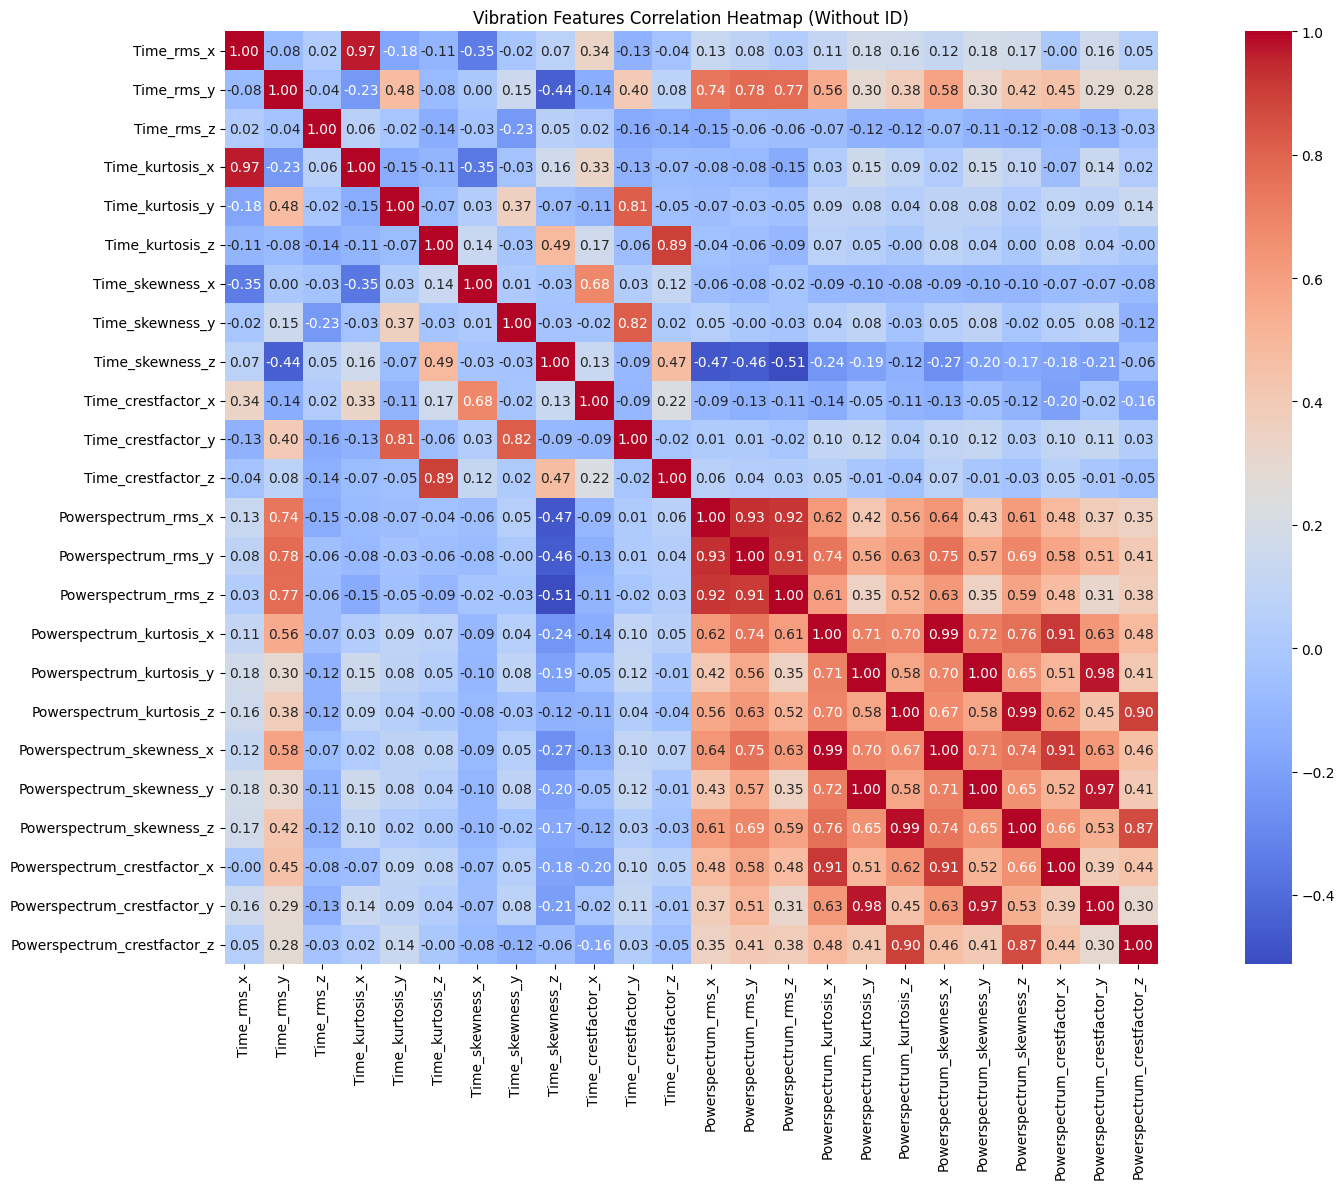

In [ ]:
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt

# 讀取原始 CSV
df = pd.read_csv("merge_inspection_data_20250715.csv")

# 儲存所有解析後的 dict
vibration_dicts = []

# 處理 vibration_features 欄位
for raw in df["vibration_features"]:
    if pd.isna(raw):
        vibration_dicts.append({})
        continue
    try:
        cleaned = re.sub(r"[{}\"]", "", raw)
        pairs = cleaned.split(",")
        entry = {}
        for p in pairs:
            if ":" in p:
                key, value = p.split(":")
                entry[key.strip()] = value.strip()
        vibration_dicts.append(entry)
    except Exception as e:
        print("Error parsing:", raw)
        vibration_dicts.append({})

# 建立 vibration 特徵 DataFrame，並轉為數值
df_Vibration = pd.DataFrame(vibration_dicts)
df_Vibration = df_Vibration.apply(pd.to_numeric, errors='coerce')

# 把原始的 ID 欄加入作為識別用途
df_Vibration["ID"] = df["id"]  # 確認欄位是 "id"，不是 "ID"

# 計算相關係數（排除 ID 欄）
corr_matrix = df_Vibration.drop(columns=["ID"]).corr()

# 畫熱圖
plt.figure(figsize=(18, 12))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Vibration Features Correlation Heatmap (Without ID)")
plt.tight_layout()
plt.show()

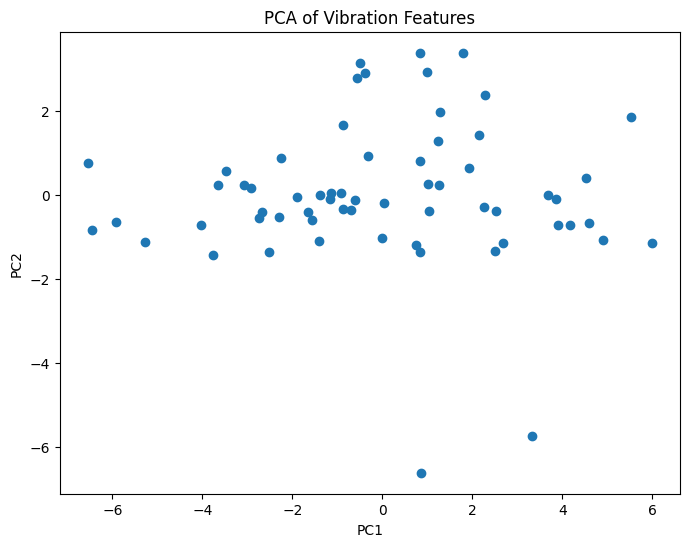

PC1貢獻最大特徵：
Powerspectrum_kurtosis_x       0.312938
Powerspectrum_skewness_x       0.312387
Powerspectrum_rms_y            0.300329
Powerspectrum_skewness_z       0.299892
Powerspectrum_kurtosis_z       0.280235
Powerspectrum_skewness_y       0.270899
Powerspectrum_rms_x            0.269330
Powerspectrum_kurtosis_y       0.268713
Powerspectrum_crestfactor_x    0.264185
Powerspectrum_rms_z            0.259701
dtype: float64


In [104]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# 移除 ID
X = df_Vibration.drop(columns=["ID"])

# 標準化
X_scaled = StandardScaler().fit_transform(X)

# PCA 降維
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# 可視化
import matplotlib.pyplot as plt
plt.figure(figsize=(8,6))
plt.scatter(X_pca[:,0], X_pca[:,1])
plt.title("PCA of Vibration Features")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

# 看各特徵對 PC1 的貢獻
loading_scores = pd.Series(pca.components_[0], index=X.columns)
top_features = loading_scores.abs().sort_values(ascending=False)
print("PC1貢獻最大特徵：")
print(top_features.head(10))


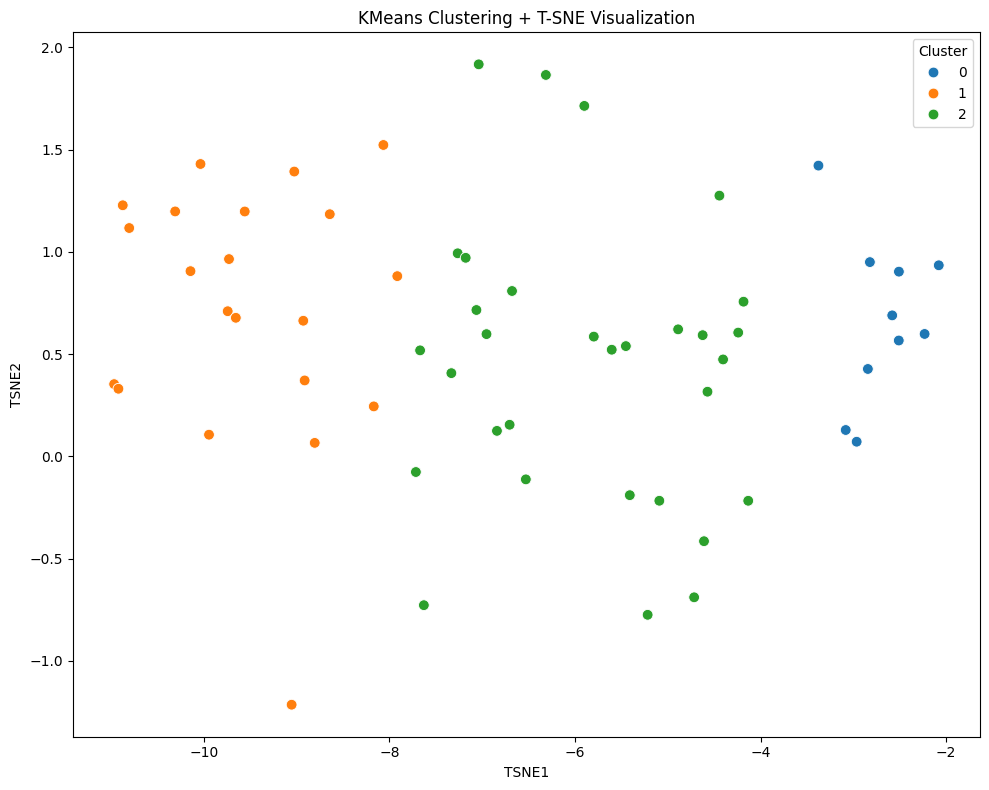

In [112]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1：選擇篩選過的特徵
selected_features = [
    "Powerspectrum_kurtosis_x",
    "Powerspectrum_skewness_x",
    "Powerspectrum_rms_y",
    "Powerspectrum_skewness_z",
    "Powerspectrum_kurtosis_z",
    "Powerspectrum_skewness_y",
    "Powerspectrum_rms_x"
]

X = df_Vibration[selected_features].copy()

# Step 2：標準化
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 3：KMeans 分群
kmeans = KMeans(n_clusters=3, random_state=42, n_init='auto')  # 可依情況改成 n_clusters=2,4...
cluster_labels = kmeans.fit_predict(X_scaled)

# Step 4：T-SNE 降維 (2D)
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_tsne = tsne.fit_transform(X_scaled)

# Step 5：可視化
tsne_df = pd.DataFrame(X_tsne, columns=["TSNE1", "TSNE2"])
tsne_df["Cluster"] = cluster_labels
df_Vibration["Kmeans"] = cluster_labels

plt.figure(figsize=(10, 8))
sns.scatterplot(
    x="TSNE1", y="TSNE2",
    hue="Cluster",
    palette="tab10",
    data=tsne_df,
    s=60
)
plt.title("KMeans Clustering + T-SNE Visualization")
plt.legend(title="Cluster")
plt.tight_layout()
plt.show()

In [124]:
import joblib

# 儲存模型
joblib.dump(kmeans, "kmeans_model.pkl")

# 若也要儲存 scaler（標準化器）
joblib.dump(scaler, "scaler.pkl")

import joblib
import pandas as pd

# 載入模型
kmeans = joblib.load("kmeans_model.pkl")
scaler = joblib.load("scaler.pkl")

# 準備新資料
new_data = pd.DataFrame([
    {
        "Powerspectrum_kurtosis_x": 0.68,
        "Powerspectrum_skewness_x": 0.65,
        "Powerspectrum_rms_y": 0.52,
        "Powerspectrum_skewness_z": 0.55,
        "Powerspectrum_kurtosis_z": 0.60,
        "Powerspectrum_skewness_y": 0.48,
        "Powerspectrum_rms_x": 0.59
    }
])

# 標準化後預測
for i in range(len(df_Vibration)):
    row = df_Vibration[selected_features].iloc[i].to_frame().T  # 轉成 DataFrame
    row_scaled = scaler.transform(row)
    pred_cluster = kmeans.predict(row_scaled)

    print(fr'第 {i} 筆預測分群編號： {pred_cluster[0]} Act:{df_Vibration["Kmeans"].iloc[i]}')


第 0 筆預測分群編號： 1 Act:1
第 1 筆預測分群編號： 1 Act:1
第 2 筆預測分群編號： 1 Act:1
第 3 筆預測分群編號： 1 Act:1
第 4 筆預測分群編號： 1 Act:1
第 5 筆預測分群編號： 2 Act:2
第 6 筆預測分群編號： 2 Act:2
第 7 筆預測分群編號： 2 Act:2
第 8 筆預測分群編號： 2 Act:2
第 9 筆預測分群編號： 1 Act:1
第 10 筆預測分群編號： 2 Act:2
第 11 筆預測分群編號： 2 Act:2
第 12 筆預測分群編號： 2 Act:2
第 13 筆預測分群編號： 2 Act:2
第 14 筆預測分群編號： 1 Act:1
第 15 筆預測分群編號： 2 Act:2
第 16 筆預測分群編號： 0 Act:0
第 17 筆預測分群編號： 2 Act:2
第 18 筆預測分群編號： 1 Act:1
第 19 筆預測分群編號： 2 Act:2
第 20 筆預測分群編號： 1 Act:1
第 21 筆預測分群編號： 2 Act:2
第 22 筆預測分群編號： 0 Act:0
第 23 筆預測分群編號： 0 Act:0
第 24 筆預測分群編號： 2 Act:2
第 25 筆預測分群編號： 1 Act:1
第 26 筆預測分群編號： 0 Act:0
第 27 筆預測分群編號： 0 Act:0
第 28 筆預測分群編號： 1 Act:1
第 29 筆預測分群編號： 0 Act:0
第 30 筆預測分群編號： 2 Act:2
第 31 筆預測分群編號： 0 Act:0
第 32 筆預測分群編號： 2 Act:2
第 33 筆預測分群編號： 2 Act:2
第 34 筆預測分群編號： 2 Act:2
第 35 筆預測分群編號： 1 Act:1
第 36 筆預測分群編號： 2 Act:2
第 37 筆預測分群編號： 2 Act:2
第 38 筆預測分群編號： 2 Act:2
第 39 筆預測分群編號： 1 Act:1
第 40 筆預測分群編號： 2 Act:2
第 41 筆預測分群編號： 0 Act:0
第 42 筆預測分群編號： 2 Act:2
第 43 筆預測分群編號： 1 Act:1
第 44 筆預測分群編號： 0 Act:0
第 45 筆預測分群編號： 1 Act: